# Notebook for cleaning and merging all 19 WorldClim datasets

In [1]:
import matplotlib.pyplot as plt
import rioxarray as rxr
import os
import re
import numpy as np
import pandas as pd
import janitor

## Set variables to subset Germany and run a single dataset

In [2]:
# Variables for dataset
size = '30s' # 10m is least granular, 30s is most granular
dat_nr = '1'

# Coordinates for Germany to subset data
coords_germany = {'lon_lower': 5.7, 
                 'lat_lower': 47.1, 
                 'lon_upper': 15.4, 
                 'lat_upper': 55.1
                }

# File paths
file_path = f'../raw_data/wc2.1_{size}_bio/wc2.1_{size}_bio_{dat_nr}.tif'

In [3]:
def get_worldclim_data(file_path, plot=False, coords=False, val='val'):
    '''
    Function for cleaning one of the 19 worldclim datasets.
    '''
    dataarray = rxr.open_rasterio(file_path)
    df = dataarray[0].to_pandas()

    if coords:
        # subsetting based on coords dictionary
        subset_lon = np.logical_and(df.columns >= coords['lon_lower'],
                                    df.columns <= coords['lon_upper'])

        subset_lat = np.logical_and(df.index   >= coords['lat_lower'],
                                    df.index   <= coords['lat_upper'])

        df = df.iloc[subset_lat, subset_lon]


    if plot:
        fig, ax = plt.subplots(figsize=(16, 5))

        # masking values
        df_masked = np.ma.masked_where((-273 > df), df)

        # set axis
        x_min = round((df.columns).min())
        x_max = round((df.columns).max())
        y_min = round((df.index).min())
        y_max = round((df.index).max())

        # use imshow so that we have something to map the colorbar to
        image = ax.imshow(df_masked,
                          extent=[x_min, x_max, y_min, y_max])

        # add colorbar using the now hidden image
        fig.colorbar(image, ax=ax)
        plt.show()

    df = df.unstack(level=-1)
    df = df.reset_index()
    df.columns = ['lon_lower', 'lat_upper', val]

    # Getting upper and lower bounds of boxes
    lon_df = pd.DataFrame({'lon_lower': sorted(df['lon_lower'].unique())})
    lon_df['lon_upper'] = lon_df['lon_lower'].shift(-1)

    lat_df = pd.DataFrame({'lat_upper': sorted(df['lat_upper'].unique(), reverse=True)})
    lat_df['lat_lower'] = lat_df['lat_upper'].shift(-1)
    lat_df

    df = df.merge(lon_df, how='left')
    df = df.merge(lat_df, how='left')

    df = df[['lon_lower', 'lon_upper', 'lat_lower', 'lat_upper', val]]

    df.dropna(inplace=True)

    return df


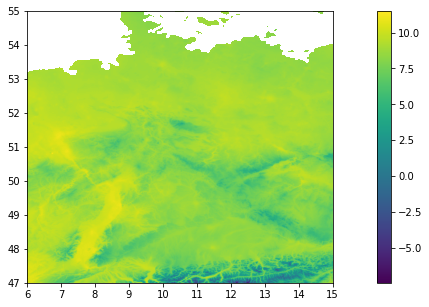

,lon_lower,lon_upper,lat_lower,lat_upper,val
0,5.704167,5.712500,55.087500,55.095833,-3.400000e+38
1,5.704167,5.712500,55.079167,55.087500,-3.400000e+38
2,5.704167,5.712500,55.070833,55.079167,-3.400000e+38
3,5.704167,5.712500,55.062500,55.070833,-3.400000e+38
4,5.704167,5.712500,55.054167,55.062500,-3.400000e+38
...,...,...,...,...,...
1116474,15.387500,15.395833,47.137500,47.145833,8.300000e+00
1116475,15.387500,15.395833,47.129167,47.137500,8.595834e+00
1116476,15.387500,15.395833,47.120833,47.129167,8.937500e+00
1116477,15.387500,15.395833,47.112500,47.120833,8.904166e+00


In [4]:
get_worldclim_data(file_path, plot=True, coords=coords_germany)

## Name of datasets (see https://worldclim.org/data/bioclim.html)
- BIO1 = Annual Mean Temperature
- BIO2 = Mean Diurnal Range (Mean of monthly (max temp - min temp))
- BIO3 = Isothermality (BIO2/BIO7) (×100)
- BIO4 = Temperature Seasonality (standard deviation ×100)
- BIO5 = Max Temperature of Warmest Month
- BIO6 = Min Temperature of Coldest Month
- BIO7 = Temperature Annual Range (BIO5-BIO6)
- BIO8 = Mean Temperature of Wettest Quarter
- BIO9 = Mean Temperature of Driest Quarter
- BIO10 = Mean Temperature of Warmest Quarter
- BIO11 = Mean Temperature of Coldest Quarter
- BIO12 = Annual Precipitation
- BIO13 = Precipitation of Wettest Month
- BIO14 = Precipitation of Driest Month
- BIO15 = Precipitation Seasonality (Coefficient of Variation)
- BIO16 = Precipitation of Wettest Quarter
- BIO17 = Precipitation of Driest Quarter
- BIO18 = Precipitation of Warmest Quarter
- BIO19 = Precipitation of Coldest Quarter

In [32]:
def get_worldclim_data_all(dir_path='../raw_data/wc2.1_30s_bio/', coords=False):
    '''
    Wrapper for get_worldclim_data(). Given a directory, it cleans and merges
    all datasets in that directory.
    '''
    # get all files in directory
    files = os.listdir(dir_path)
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    data = {}

    # clean each dataset
    for file in files:
        val = re.findall('bio_\d+', file)[0]
        df = get_worldclim_data(dir_path + file, plot=False, coords=coords, val=val)
        data[val] = df

    # merge datasets
    i = 0
    for key in data:
        if i == 0:
            df = data[key]
        else:
            df = df.merge(data[key], how='inner')

        i += 1

    return df

In [21]:
# Get all data
data = get_worldclim_data_all(dir_path='../raw_data/wc2.1_30s_bio/', coords=coords_germany)
data

,lon_lower,lon_upper,lat_lower,lat_upper,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
0,5.704167,5.712500,55.087500,55.095833,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38
1,5.704167,5.712500,55.079167,55.087500,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38
2,5.704167,5.712500,55.070833,55.079167,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38
3,5.704167,5.712500,55.062500,55.070833,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38
4,5.704167,5.712500,55.054167,55.062500,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115312,15.387500,15.395833,47.137500,47.145833,8.300000e+00,9.500000e+00,3.298611e+01,7.289843e+02,2.330000e+01,-5.500000e+00,...,1.723333e+01,-6.999999e-01,9.110000e+02,1.300000e+02,3.200000e+01,4.433024e+01,3.730000e+02,1.150000e+02,3.730000e+02,1.150000e+02
1115313,15.387500,15.395833,47.129167,47.137500,8.595834e+00,9.425000e+00,3.261246e+01,7.358745e+02,2.360000e+01,-5.300000e+00,...,1.758333e+01,-5.166667e-01,8.800000e+02,1.280000e+02,2.900000e+01,4.638049e+01,3.670000e+02,1.060000e+02,3.670000e+02,1.060000e+02
1115314,15.387500,15.395833,47.120833,47.129167,8.937500e+00,9.291667e+00,3.204023e+01,7.464952e+02,2.400000e+01,-5.000000e+00,...,1.803333e+01,-3.333333e-01,8.430000e+02,1.240000e+02,2.600000e+01,4.839793e+01,3.580000e+02,9.700000e+01,3.580000e+02,9.700000e+01
1115315,15.387500,15.395833,47.112500,47.120833,8.904166e+00,9.358334e+00,3.204909e+01,7.485181e+02,2.410000e+01,-5.100000e+00,...,1.803333e+01,-3.833333e-01,8.500000e+02,1.250000e+02,2.700000e+01,4.795243e+01,3.600000e+02,9.900000e+01,3.600000e+02,9.900000e+01


In [12]:
# Save as csv
data.to_csv('../raw_data/wc2.1_30s_bio_germany.csv', index=False)

In [33]:
# Read to check output
df = pd.read_csv('../raw_data/wc2.1_30s_bio_germany.csv')
df

## Merge with occurences

In [ ]:
def append_worldclim_features(occurences, csv=True, bioclim_path='../raw_data/wc2.1_30s_bio_germany.csv'):
    '''
    Appends 19 bioclimatic features to a given occurences dataset. occurences can either be a path to a 
    csv-file or a dictionary containing latitude and longitude. In the latter case the csv-flag must be 
    set to False
    '''
    if csv:
        occurences = pd.read_csv(occurences)
    else: 
        occurences = pd.DataFrame(occurences)
        
    bioclim_vars = pd.read_csv(bioclim_path)
    
    df = occurences.conditional_join(bioclim_vars, 
                                 ('latitude', 'lat_lower', '>='),
                                 ('latitude', 'lat_upper', '<'),
                                 ('longitude', 'lon_lower', '>='),
                                 ('longitude', 'lon_upper', '<'), 
                                 how='inner')

    df = df.drop(columns=['lon_lower', 'lon_upper', 'lat_lower', 'lat_upper'])
    
    return df

In [ ]:
occurences = pd.read_csv('../raw_data/occurences.csv')

In [ ]:
%%time
idx = 10**6
df1 = append_worldclim_features(occurences.iloc[:idx], csv=False)
df2 = append_worldclim_features(occurences.iloc[idx:], csv=False)
df_all = pd.concat([df1, df2], ignore_index=True)
df_all.to_csv('../raw_data/occurences_worldclim.csv')